In [4]:
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import preprocess_input

In [5]:
# ukuran gambar (ikut contoh)
img_width  = 136
img_height = 102

# path folder dataset
dataset_path = './flower_images/'

# ambil nama-nama kelas dari nama folder
classes = os.listdir(dataset_path)

print("Classes:", classes)

# list untuk menampung data dan label
x = []
y = []

counter = 0

Classes: ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']


In [6]:
# import gambar ke dalam x dan label ke dalam y

for class_index, class_name in enumerate(classes):
    class_folder = os.path.join(dataset_path, class_name)

    for img_name in os.listdir(class_folder):
        path = os.path.join(class_folder, img_name)
        
        # load gambar dan ubah ukurannya
        # (target_size = (height, width))
        img = tf.keras.preprocessing.image.load_img(
            path,
            target_size=(img_height, img_width)
        )
        
        # ubah gambar jadi array (H, W, 3)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        
        # masukkan ke list x
        x.append(img_array)
        
        # label = index kelas (0,1,2,3,4)
        y.append(class_index)
    counter += 1

print("Total images:", len(x))
print("Total labels:", len(y))

Total images: 5000
Total labels: 5000


In [7]:
# ubah list jadi numpy array
x = np.array(x, dtype='float32')
y = np.array(y)

print("x shape before norm:", x.shape)
print("y shape:", y.shape)

# normalisasi piksel 0–255 -> 0–1
x = x / 255.0

print("x min:", x.min(), "x max:", x.max())

x shape before norm: (5000, 102, 136, 3)
y shape: (5000,)
x min: 0.0 x max: 1.0


In [8]:
# split pertama: train dan "sisa" (sementara disebut test)
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=400
)

# split kedua: dari x_test lagi dibagi jadi val dan test final
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test,
    test_size=0.2,
    random_state=400
)

# pastikan y jadi vector 1D integer (bukan (N,1))
y_train = np.squeeze(y_train)
y_val   = np.squeeze(y_val)
y_test  = np.squeeze(y_test)

print("y_train shape before one-hot:", y_train.shape)

num_classes = 5  # Lily, Lotus, Orchid, Sunflower, Tulip

# ubah ke one-hot
y_train = to_categorical(y_train, num_classes=num_classes)
y_val   = to_categorical(y_val,   num_classes=num_classes)
y_test  = to_categorical(y_test,  num_classes=num_classes)

print("y_train shape after one-hot:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)


# ubah label integer -> one-hot
x_train_pt = preprocess_input(x_train * 255.0)
x_val_pt   = preprocess_input(x_val   * 255.0)
x_test_pt  = preprocess_input(x_test  * 255.0)

print("x_train_pt:", x_train_pt.shape)
print("x_val_pt  :", x_val_pt.shape)
print("x_test_pt :", x_test_pt.shape)

y_train shape before one-hot: (4000,)
y_train shape after one-hot: (4000, 5)
y_val shape: (800, 5)
y_test shape: (200, 5)
x_train_pt: (4000, 102, 136, 3)
x_val_pt  : (800, 102, 136, 3)
x_test_pt : (200, 102, 136, 3)


# EfficientNET

In [9]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Base model EfficientNetB0 pretrained
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

# Freeze base model (tahap 1 = feature extractor)
base_model.trainable = False

model_pt = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_pt.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_pt.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 4, 5, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 4,378,792
Trainable params: 329,221
Non-trainable params: 4,049,571
________________________________________

In [10]:
history_pt_stage1 = model_pt.fit(
    x_train_pt,
    y_train,
    validation_data=(x_val_pt, y_val),
    batch_size=64,
    epochs=20
)

Epoch 1/20
63/63 [==============================] - 8s 53ms/step - loss: 1.3730 - accuracy: 0.4437 - val_loss: 1.0087 - val_accuracy: 0.7025
Epoch 2/20
63/63 [==============================] - 2s 36ms/step - loss: 0.9180 - accuracy: 0.6867 - val_loss: 0.7407 - val_accuracy: 0.7875
Epoch 3/20
63/63 [==============================] - 2s 31ms/step - loss: 0.7307 - accuracy: 0.7467 - val_loss: 0.6148 - val_accuracy: 0.8138
Epoch 4/20
63/63 [==============================] - 2s 31ms/step - loss: 0.6301 - accuracy: 0.7883 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 5/20
63/63 [==============================] - 2s 31ms/step - loss: 0.5711 - accuracy: 0.8043 - val_loss: 0.4940 - val_accuracy: 0.8375
Epoch 6/20
63/63 [==============================] - 2s 31ms/step - loss: 0.5260 - accuracy: 0.8227 - val_loss: 0.4660 - val_accuracy: 0.8512
Epoch 7/20
63/63 [==============================] - 2s 31ms/step - loss: 0.4890 - accuracy: 0.8322 - val_loss: 0.4348 - val_accuracy: 0.8512
Epoch 8/20
63

In [11]:
test_loss_pt1, test_acc_pt1 = model_pt.evaluate(x_test_pt, y_test, verbose=0)
print("Test loss (pretrained - stage 1):", test_loss_pt1)
print("Test acc  (pretrained - stage 1):", test_acc_pt1)


Test loss (pretrained - stage 1): 0.2951973080635071
Test acc  (pretrained - stage 1): 0.875


In [ ]:
# Cek jumlah layer di base_model
print("Total layers in base_model:", len(base_model.layers))

# Misal kita fine-tune 20 layer terakhir
fine_tune_at = 20

# Freeze semua layer dulu
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze 20 layer terakhir
for layer in base_model.layers[-fine_tune_at:]:
    layer.trainable = True

# Cek status trainable
trainable_count = np.sum([layer.trainable for layer in base_model.layers])
print("Trainable layers in base_model after setup:", trainable_count)


Total layers in base_model: 238
Trainable layers in base_model after setup: 20


In [13]:
from tensorflow.keras.optimizers import Adam

model_pt.compile(
    optimizer=Adam(learning_rate=1e-5),  # lebih kecil dari tahap 1
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [14]:
history_pt_ft = model_pt.fit(
    x_train_pt,
    y_train,
    validation_data=(x_val_pt, y_val),
    batch_size=64,
    epochs=20
)

Epoch 1/20
63/63 [==============================] - 7s 53ms/step - loss: 0.5860 - accuracy: 0.8112 - val_loss: 0.3631 - val_accuracy: 0.8800
Epoch 2/20
63/63 [==============================] - 2s 34ms/step - loss: 0.5753 - accuracy: 0.8200 - val_loss: 0.4293 - val_accuracy: 0.8562
Epoch 3/20
63/63 [==============================] - 2s 32ms/step - loss: 0.5505 - accuracy: 0.8270 - val_loss: 0.4711 - val_accuracy: 0.8525
Epoch 4/20
63/63 [==============================] - 2s 32ms/step - loss: 0.5438 - accuracy: 0.8322 - val_loss: 0.4926 - val_accuracy: 0.8487
Epoch 5/20
63/63 [==============================] - 2s 32ms/step - loss: 0.5443 - accuracy: 0.8335 - val_loss: 0.5019 - val_accuracy: 0.8487
Epoch 6/20
63/63 [==============================] - 2s 32ms/step - loss: 0.5269 - accuracy: 0.8350 - val_loss: 0.5045 - val_accuracy: 0.8500
Epoch 7/20
63/63 [==============================] - 2s 31ms/step - loss: 0.5161 - accuracy: 0.8457 - val_loss: 0.5029 - val_accuracy: 0.8500
Epoch 8/20
63

In [15]:
test_loss_pt2, test_acc_pt2 = model_pt.evaluate(x_test_pt, y_test, verbose=0)
print("Test loss (pretrained - fine-tuned):", test_loss_pt2)
print("Test acc  (pretrained - fine-tuned):", test_acc_pt2)


Test loss (pretrained - fine-tuned): 0.427061527967453
Test acc  (pretrained - fine-tuned): 0.8450000286102295


In [16]:
from sklearn.metrics import classification_report
import numpy as np

# EVAL-2: Prediksi kelas di test set
y_true = np.argmax(y_test, axis=1)   # dari one-hot ke index kelas

y_pred_prob = model_pt.predict(x_test_pt)
y_pred = np.argmax(y_pred_prob, axis=1)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes)) 

7/7 [==============================] - 1s 16ms/step
Classification Report:

              precision    recall  f1-score   support

       Lilly       0.77      0.73      0.75        37
       Lotus       0.82      0.82      0.82        33
      Orchid       0.83      0.91      0.87        44
   Sunflower       0.97      0.86      0.91        37
       Tulip       0.84      0.88      0.86        49

    accuracy                           0.84       200
   macro avg       0.85      0.84      0.84       200
weighted avg       0.85      0.84      0.84       200



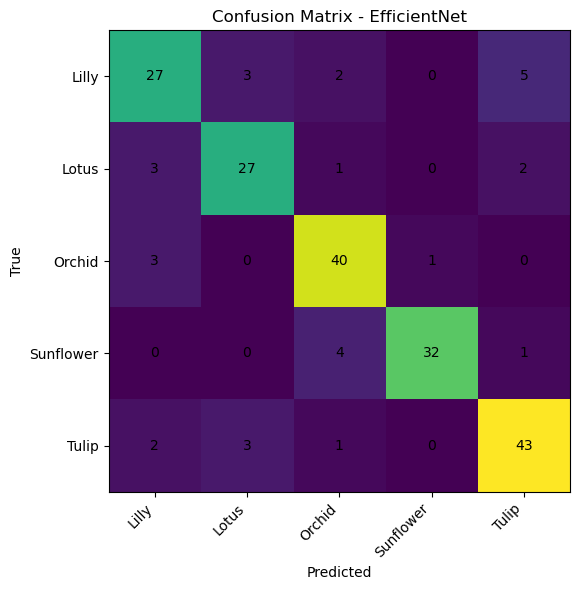

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# EVAL-3: Confusion matrix
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm)

ax.set_xticks(range(len(classes)))
ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.set_yticklabels(classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i, j], ha="center", va="center")

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix - EfficientNet")
plt.tight_layout()
plt.show()


In [ ]:
# model_pt.save_weights("efficientnet_flower.h5")